In [1]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib, tarfile, shutil, os, glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
%matplotlib inline
from IPython.display import HTML
HTML('''<script> code_show=true; 
function code_toggle() {
if (code_show){$('div.input').hide();}
else {$('div.input').show();}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script> To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')                             

In [168]:
font = {'size'   : 12}

matplotlib.rc('font', **font)

names = {"0": "Splicer", "1": "Worker", "2": "PersistentDB",
         "3": "InMemoryDB", "4": "WorkManager", -1: "all ranks"}

def untar(fname):
    try: shutil.rmtree("tmp")
    except: pass
    os.mkdir("tmp")
    tar = tarfile.open(fname)
    tar.extractall()
    tar.close()
d = "../experiments/baseline-trinitite/"
def plot_times(ax, label, results):
    #colors = ['#8c510a', '#d8b365', '#f6e8c3', '#c7eae5', '#5ab4ac', '#01665e']
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    ax.plot(df["wc"], df["traj"], label=label, lw=2)
    ax.set_ylabel("Trajectory Length (pico seconds)")
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax.legend()

## Motivation: Keyspace 

The ParSplice keyspace is small (numbers above bars) but must satisfy many reads as workers calculate new segments. The active keyspace is difficult to predict a priori but the optimal load balancing strategy strikes a good balance between preformance and utiization. 

In [153]:
### Boring Parsing Info
# The data structure we read into is a dictionary, where the key is a tuple that identifies the job and the 
# value is a tuple with parsed data in Python data frames. The `parse()` function reads the raw data and 
# puts it into the dictionary:
#
# dfs[(name, op, rank)] => {KEY TIMES, KEY COUNT}
#
# where `name` is a human readable string that describes the job, `op` is the type of database operation,
# `rank` is the MPI rank number, `KEY TIMES` has keys and timestamps, and `KEY COUNT` has keys and counts (i.e. # 
# of occurences). We save `countDF` because it takes forever to parse this data.
def parse(dfs, name, results):
    stats = []
    for rank in ["0", "1", "2", "3", "4"]:
        untar(results + "/out/semanticPerf." + rank + ".tar.gz")
        shutil.move("semanticPerf." + rank, "tmp/semanticPerf." + rank)
        for op in ["DBMemoryPut", "DBMemoryGet"]:
            os.system("cat tmp/semanticPerf." + rank + " | grep " + op + " > tmp/keyspace.log")
            df_op = pd.read_csv("tmp/keyspace.log", names=['ts', 'op', 'dbkey', 'key'])
            if len(df_op) == 0: 
                continue           
            dfs[(name, op, rank)] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = {}
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = df_op
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = df_op.groupby('key').size().reset_index()
            dfs[(name, op, rank)]['DF_KEY_COUNT'].columns=['key', 'count']

            # print stats
            stat = dfs[(name, op, rank)]['DF_KEY_COUNT']
            hotK = stat.loc[stat['count'].idxmax()]
            stats.append(name + " " + op + " " + names[rank] + ": nkeys=" + str(len(stat['key']))
                         + ", hottest key=" + str(hotK[0]) + " (count=" + str(hotK[1]) + ")")
    print "... done: " + os.path.basename(results)
    return stats

In [154]:
dfs = {}   # global data structure with parsed data
stats = [] # dumps stats at the end
stats.append(parse(dfs, "4 Node, 100K", d+"nano-sepminima/scale-keyspace-trace/scale-workers-4-71541/"))
stats.append(parse(dfs, "4 Node, 1M",   d+"nano-sepminima/scale-keyspace-trace/scale-workers-1M-4-71537/"))
stats.append(parse(dfs, "1 Node, 100K", d+"nano-sepminima/scale-keyspace-trace/scale-workers-1-71538"))
stats.append(parse(dfs, "1 Node, 1M",   d+"nano-sepminima/scale-keyspace-trace/scale-workers-1M-1-71684"))

... done: 
... done: 
... done: scale-workers-1-71538
... done: scale-workers-1M-1-71684


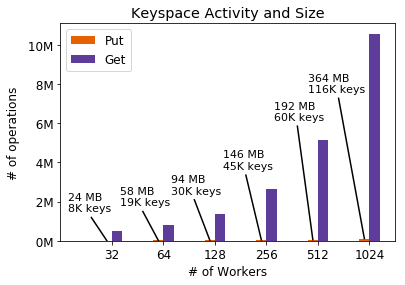

In [169]:
def get_perfcount(op, results, rank="1"):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    df = df[df['op'] == op]
    
    shift = np.min(df['ts']) * np.ones(len(df['ts']))
    df['shift'] = df['ts'] - shift
    df = df[df['shift']>=4000]
    return float(df.head(1)['count'])

def get_keyspace(results, rank="1"):
    puts = get_perfcount("DBMemoryPut", results, rank=rank)
    gets = get_perfcount("DBMemoryGet", results, rank=rank)
    size = get_perfcount("DBMemoryMapSize", results, rank=rank)
    mem  = get_perfcount("DBMemorySize", results, rank=rank)    
    return puts, gets, size, mem

puts = []; gets = []; size = []; mem = []; label = []

label.append('32')
p, g, s, m = get_keyspace(d+"nano-sepminima/scale-workers-1to8n/scale-workers-1-71033")
puts.append(p); gets.append(g); size.append(s); mem.append(m)

label.append('64')
p, g, s, m = get_keyspace(d+"nano-sepminima/scale-workers-1to8n/scale-workers-2-71035")
puts.append(p); gets.append(g); size.append(s); mem.append(m)
    
label.append('128')
p, g, s, m = get_keyspace(d+"nano-sepminima/scale-workers-1to8n/scale-workers-4-71036")
puts.append(p); gets.append(g); size.append(s); mem.append(m)

label.append('256')
p, g, s, m = get_keyspace(d+"nano-sepminima/scale-mantle-workers/scale-mantle-unlimited-71705")
puts.append(p); gets.append(g); size.append(s); mem.append(m)

label.append('512')
p, g, s, m = get_keyspace(d+"nano-sepminima/scale-workers-1to8n/scale-workers-16-71161")
puts.append(p); gets.append(g); size.append(s); mem.append(m)

label.append('1024')
p, g, s, m = get_keyspace(d+"nano-sepminima/scale-keyspace-trace/scale-workers-32-71694/")
p1, g1, s1, m1 = get_keyspace(d+"nano-sepminima/scale-keyspace-trace/scale-workers-32-71694/", rank="2")
puts.append(p+p1); gets.append(g+g1); size.append(s+s1); mem.append(m+m1)

fig, ax = plt.subplots(1, 1)
x = np.arange(len(puts))
ax.bar(x - 0.1, puts, width=0.2, label="Put", color='#e66101')
ax.bar(x + 0.1, gets, width=0.2, label="Get", color='#5e3c99')
ax.set_xticks(range(0, len(label)))
ax.set_xticklabels(label)
ax.set_title("Keyspace Activity and Size")
ax.set_ylabel("# of operations")
ax.set_xlim(-1, 5.5)
ax.legend(loc='upper left')
ax.set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax.get_yticks()])
ax.set_xlabel("# of Workers")

# put the annotations
for i,j in zip(x,gets):
    if i == 5: break
    ax.annotate(str(int(mem[i]/(1000*1000))) + " MB\n" + str(int(size[i]/1000)) + "K keys",
                xy=(i-0.85,j+1000*1000),fontsize=11)
    ax.plot([i-0.4, i-0.1], [j+1000*700, puts[i]], 'k-')

ax.annotate(str(int(mem[5]/(1000*1000))) + " MB\n" + str(int(size[5]/1000)) + "K keys",
            xy=(i-1.2,j-3*1000*1000),fontsize=11)
ax.plot([i-0.6, i-0.1], [j-3*1000*1100, puts[i]], 'k-')

fig.savefig("../paper/figures/methodology-keyspace.png", bbox_inches='tight', dpi=400)

In [6]:
[float(a)/float(b) for a,b in zip(WorkManagerG,WorkManager)]

[55.86762413716322,
 40.30563885747997,
 42.362037118480075,
 55.43007415766564,
 80.52544106366658,
 84.15469536911927]

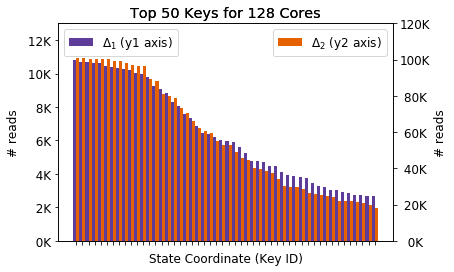

In [210]:
### Figure 2
def plot_keyspace(ax, dfs, key, shift=0, nkeys=50, color="", label=""):
    # parse and ingest
    dftop = dfs[key]['DF_KEY_COUNT'].nlargest(nkeys, 'count').head(50) # not sure why we need to do head here

    # plot it (break if we don't find any ops)
    if len(dftop) == 0: return -1
    x = np.arange(len(dftop['key']))
    ax.bar(x + shift, dftop['count'], width=0.5, label=label, color=color)

    # cleanup graphs
    ax.set_xticks(x)
    ax.set_xticklabels([])
    ax.set_xlabel("State Coordinate (Key ID)")
    ax.set_ylabel("# reads")    
    ax.set_title("Top " + str(nkeys) + " Keys for 128 Cores")
    ax.legend()

fig, ax = plt.subplots(1, 1)
ax2 = ax.twinx()
for op in ["DBMemoryGet"]:
    plot_keyspace(ax2, dfs, ("4 Node, 1M", op, "4"), shift=0.25, color='#e66101', label=r'$\Delta_2$ (y2 axis)')
    plot_keyspace(ax, dfs, ("4 Node, 100K", op, "4"), shift=-0.25, color='#5e3c99', label=r'$\Delta_1$ (y1 axis)')
ax.legend(loc="upper left")
ax2.set_ylim(0, 120*1000)
ax.set_yticklabels(['{:3.0f}K'.format(x/1000) for x in ax.get_yticks()])
ax2.legend(loc='upper right')
ax.set_ylim(0, 13*1000)
ax2.set_yticklabels(['{:3.0f}K'.format(x/1000) for x in ax2.get_yticks()])

fig.savefig("../paper/figures/methodology-keys.png", bbox_inches='tight', dpi=400)

## Motivation: Trade-off

NameError: name 'plot_times' is not defined

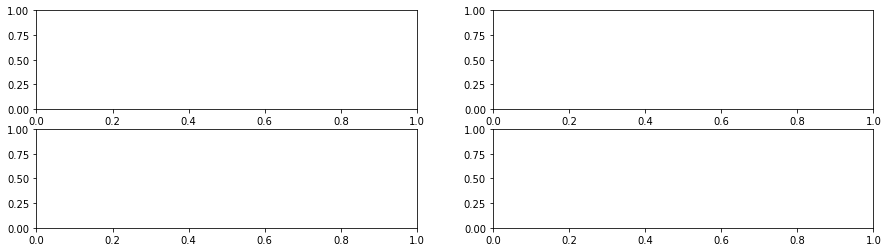

In [8]:
def plot_keyspace(ax, op, results, rank="1", label=""):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    
    df = df[df['op'] == op]
    shift = np.min(df['ts']) * np.ones(len(df['ts']))
    
    df['cs'] = df['count'].astype(float) - df['count'].shift(1).astype(float)
    ax.plot(df['ts'].astype(float) - shift, df['cs'].astype(float), label=label)
    ax.set_xlabel("Time (seconds)")

fig, axis = plt.subplots(2, 2, figsize=(15, 4))
ax = axis[0][0]
plot_times(ax, "10 Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10-72366")
plot_times(ax, "100 Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100-72361")
plot_times(ax, "1K Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-1000-72378")
plot_times(ax, "10K Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72374")
#plot_times(ax, "10K Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72363")
plot_times(ax, "100K Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100000-72380")
plot_times(ax, "Unlimited", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-71994")
ax.legend(ncol=2)
#ax.set_ylim(5*1000*1000, 6*1000*1000)
ax.set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax.get_yticks()])

def plot_keyspace(ax, op, results, rank="1", label=""):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    
    #ax.set_title("# Keys (y1) vs. Size of Data (y2)")
    df_op = df[df['op'] == op]
    shift = np.min(df_op['ts']) * np.ones(len(df_op['ts']))
    if label == "":
        label = os.path.basename(results).split('-')[3] + " Keys"
    ax.plot(df_op['ts'].astype(float) - shift, df_op['count'].astype(float), label=label)
    ax.set_xlabel("Time (seconds)")
    ax.set_title(op)
    ax.legend(ncol=2)
#ax.set_xlim(0, 10000)
#ax.set_ylim(4*1000*1000, 5*1000*1000)

ax = axis[1][0]
plot_keyspace(ax, "DBMemoryMapSize", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10-72366")
plot_keyspace(ax, "DBMemoryMapSize", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100-72361")
plot_keyspace(ax, "DBMemoryMapSize", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72363")
plot_keyspace(ax, "DBMemoryMapSize", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100000-72380")
#ax.set_xlim(0, 10000)

def plot_keyspace(ax, op, results, rank="1", label=""):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    
    df = df[df['op'] == op]
    shift = np.min(df['ts']) * np.ones(len(df['ts']))
    
    df['cs'] = df['count'].astype(float) - df['count'].shift(1).astype(float)
    ax.plot(df['ts'].astype(float) - shift, df['cs'].astype(float), label=label)
    ax.set_xlabel("Time (seconds)")

ax = axis[0][1]
plot_times(ax, "10 Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10-72366")
#plot_times(ax, "100 Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100-72361")
#plot_times(ax, "1K Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-1000-72378")
#plot_times(ax, "10K Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72374")
#plot_times(ax, "100K Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100000-72380")
plot_times(ax, "Unlimited", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-71994")
ax.legend(ncol=2)
ax.set_xlim(6000, 10000)
ax.set_ylim(4.7*1000*1000, 5.1*1000*1000)
ax.set_yticklabels(['{:3.0f}K'.format(yval/(1000)) for yval in ax.get_yticks()])

def plot_keyspace(ax, op, results, rank="1", label=""):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    
    #ax.set_title("# Keys (y1) vs. Size of Data (y2)")
    df_op = df[df['op'] == op]
    shift = np.min(df_op['ts']) * np.ones(len(df_op['ts']))
    if label == "":
        label = os.path.basename(results).split('-')[3] + " Keys"
    ax.plot(df_op['ts'].astype(float) - shift, df_op['count'].astype(float), label=label)
    ax.set_xlabel("Time (seconds)")
    ax.set_title(op)
    ax.legend()

ax = axis[1][1]
plot_keyspace(ax, "DBMemoryMapSize", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10-72366")
#plot_keyspace(ax, "DBMemoryMapSize", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100-72361")
#plot_keyspace(ax, "DBMemoryMapSize", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72363")
plot_keyspace(ax, "DBMemoryMapSize", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-71994")
ax.set_xlim(6000, 10000)


## 2.5 Hour Run

[5354198.666666667] [530991189.3333333]
               ts               op   count   shift
22494  1504428487  DBMemoryMapSize  145257  8990.0
[5299615.0, 4855757.333333333, 3864763.6666666665, 3638892.0, 3417084.3333333335] [388075701.3333333, 38926138.666666664, 3199077.3333333335, 301282.6666666667, 28496.0]
[5299615.0, 5115339.0, 4919943.5, 4962985.0, 4963376.0] [388075701.3333333, 40721576.0, 3954004.0, 399200.0, 39920.0]


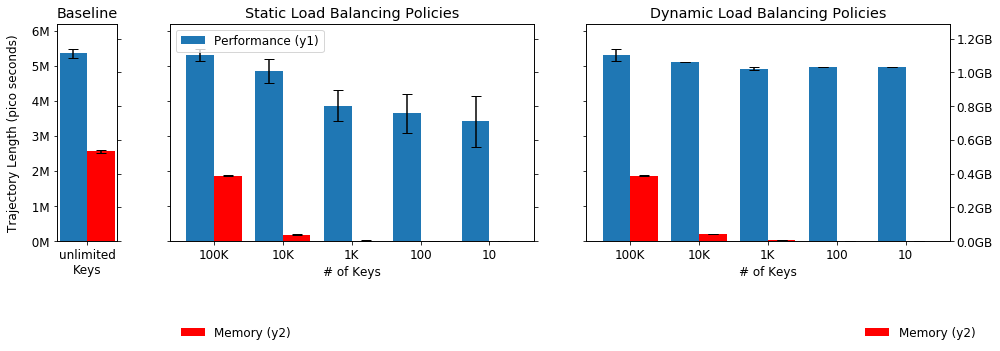

In [176]:
distance = [1,3,7,9]
energy = [10,20,30,40]
sigma = [1,3,2,5]



def get_max_op(op, results, rank="1"):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    df = df[df['op'] == op]

    shift = np.min(df['ts']) * np.ones(len(df['ts']))
    df['shift'] = df['ts'] - shift
    return df.head(int(len(df)*0.6)).tail(1)

def get_max_traj(results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    return df.head(int(len(df)*0.6)).tail(1)


# canvas
fig = plt.figure(figsize=(16, 4))
gs = plt.GridSpec(1, 3, width_ratios=[0.5, 3, 3]) 
#fig.subplots_adjust(wspace=0.25)

### FIGURE 0
trajs = []; terror = []
label = []
memory = []; merror = []
for runs in [(d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-71994",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72000",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72006")]:
    t = []; m = []
    for run in runs:
        t.append(float(get_max_traj(run)['traj']))
        m.append(float(get_max_op("DBMemorySize", run)['count']))
    l = os.path.basename(run).split('-')[3]
    if l != "unlimited":
        l = int(l)
        if l > 100:
            l = str(l / 1000) + str("K")
    l = str(l) + "\nKeys"
    label.append(l)
    trajs.append(float(np.mean(t)))
    terror.append(float(np.std(t)))
    memory.append(float(np.mean(m)))
    merror.append(float(np.std(m)))

ax = plt.subplot(gs[0])
ax.set_title("Baseline")
ax.bar(np.arange(len(trajs)) - 0.2, trajs, yerr=terror, capsize=5, width=0.4, label="Perf (y1)")
ax.set_xticks(range(0, len(trajs)))
ax.set_xticklabels(label)
ax.set_ylabel("Trajectory Length (pico seconds)")
#ax.legend(loc='upper left')
ax.set_ylim(0, 6.2*1000*1000)
ax.set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax.get_yticks()])
ax2 = ax.twinx()
ax2.bar(np.arange(len(memory)) + 0.2, memory, yerr=merror, capsize=5, width=0.4, color='r', label="Memory (y2)")
ax2.set_xticks(range(0, len(memory)))
#ax2.legend(loc='upper right')
ax2.set_ylim(0, 1.2*1024*1024*1024)
#ax2.set_yticklabels(['{:3.1f}GB'.format(yval/(1000*1000*1000)) for yval in ax2.get_yticks()])
ax2.set_yticklabels("")
print trajs, memory
print get_max_op("DBMemoryMapSize", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-71994")

### FIGURE 1
trajs = []; terror = []
label = []
memory = []; merror = []
for runs in [(d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71993",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71999",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-72005"),
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-71992",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-71998",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-72004"), 
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-71991",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-71997",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-72003"),
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-71990",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-71996",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-72002"), 
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-71989",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-71995",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-72001")]:
    t = []; m = []
    for run in runs:
        t.append(float(get_max_traj(run)['traj']))
        m.append(float(get_max_op("DBMemorySize", run)['count']))
    l = os.path.basename(run).split('-')[3]
    if l != "unlimited":
        l = int(l)
        if l > 100:
            l = str(l / 1000) + str("K")
    l = str(l)
    label.append(l)
    trajs.append(float(np.mean(t)))
    terror.append(float(np.std(t)))
    memory.append(float(np.mean(m)))
    merror.append(float(np.std(m)))

ax = plt.subplot(gs[1])
ax.set_title("Static Load Balancing Policies")
ax.bar(np.arange(len(trajs)) - 0.2, trajs, yerr=terror, capsize=5, width=0.4, label="Performance (y1)")
ax.set_xticks(range(0, len(trajs)))
ax.set_xticklabels(label)
ax.legend(loc='upper left')
ax.set_ylim(0, 6.2*1000*1000)
#ax.set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax.get_yticks()])
ax.set_yticklabels("")
ax2 = ax.twinx()
ax2.bar(np.arange(len(memory)) + 0.2, memory, yerr=merror, capsize=5, width=0.4, color='r', label="Memory (y2)")
ax2.set_xticks(range(0, len(memory)))
ax2.legend(loc='upper right')
ax2.set_ylim(0, 1.2*1024*1024*1024)
#ax2.set_yticklabels(['{:3.1f}GB'.format(yval/(1000*1000*1000)) for yval in ax2.get_yticks()])
ax2.set_yticklabels("")
ax.set_xlabel("# of Keys")
print trajs, memory

trajs = []; terror = []
label = []
memory = []; merror = []
for runs in [(d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71993",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71999",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-72005"),
            (d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72374",
             d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72374"),
            (d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-1000-72373",
             d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-1000-72378"),     
            (d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100-72372",
             d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100-72372"),           
            (d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10-72366",
             d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10-72376")    
            ]:
    t = []; m = []
    for run in runs:
        t.append(float(get_max_traj(run)['traj']))
        m.append(float(get_max_op("DBMemorySize", run)['count']))
    l = os.path.basename(run).split('-')[3]
    if l != "unlimited":
        l = int(l)
        if l > 100:
            l = str(l / 1000) + str("K")
    l = str(l)
    label.append(l)
    trajs.append(float(np.mean(t)))
    terror.append(float(np.std(t)))
    memory.append(float(np.mean(m)))
    merror.append(float(np.std(m)))

ax = plt.subplot(gs[2])
ax.set_title("Dynamic Load Balancing Policies")
ax.bar(np.arange(len(trajs)) - 0.2, trajs, yerr=terror, capsize=5, width=0.4, label="Performance (y1)")
ax.set_xticks(range(0, len(trajs)))
ax.set_xticklabels(label)
ax.set_ylim(0, 6.2*1000*1000)
ax.set_yticklabels("")
ax.set_xlabel("# of Keys")
ax2.legend(bbox_to_anchor=(0, -0.5), loc='lower left', frameon=False)

ax2 = ax.twinx()
ax2.bar(np.arange(len(memory)) + 0.2, memory, yerr=merror, capsize=5, width=0.4, color='r', label="Memory (y2)")
ax2.set_xticks(range(0, len(memory)))
ax2.legend(bbox_to_anchor=(1.1, -0.5), loc='lower right', frameon=False)
ax2.set_ylim(0, 1.2*1024*1024*1024)
ax2.set_yticklabels(['{:3.1f}GB'.format(yval/(1000*1000*1000)) for yval in ax2.get_yticks()])
print trajs, memory

fig.savefig("../paper/figures/methodology-tradeoff.png", bbox_inches='tight', dpi=400)

[5354198.666666667] [530991189.3333333]
               ts               op   count   shift
22494  1504428487  DBMemoryMapSize  145257  8990.0


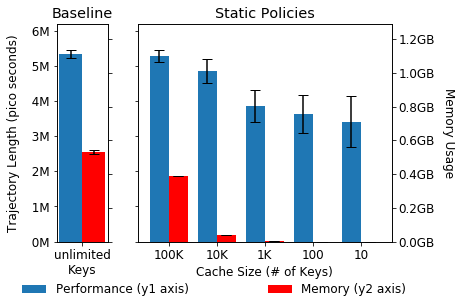

In [195]:
distance = [1,3,7,9]
energy = [10,20,30,40]
sigma = [1,3,2,5]



def get_max_op(op, results, rank="1"):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    df = df[df['op'] == op]

    shift = np.min(df['ts']) * np.ones(len(df['ts']))
    df['shift'] = df['ts'] - shift
    return df.head(int(len(df)*0.6)).tail(1)

def get_max_traj(results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    return df.head(int(len(df)*0.6)).tail(1)


# canvas
fig = plt.figure()#figsize=(16, 4))
gs = plt.GridSpec(1, 2, width_ratios=[1, 5]) 
#fig.subplots_adjust(wspace=0.25)

### FIGURE 0
trajs = []; terror = []
label = []
memory = []; merror = []
for runs in [(d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-71994",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72000",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72006")]:
    t = []; m = []
    for run in runs:
        t.append(float(get_max_traj(run)['traj']))
        m.append(float(get_max_op("DBMemorySize", run)['count']))
    l = os.path.basename(run).split('-')[3]
    if l != "unlimited":
        l = int(l)
        if l > 100:
            l = str(l / 1000) + str("K")
    l = str(l) + "\nKeys"
    label.append(l)
    trajs.append(float(np.mean(t)))
    terror.append(float(np.std(t)))
    memory.append(float(np.mean(m)))
    merror.append(float(np.std(m)))

ax = plt.subplot(gs[0])
ax.set_title("Baseline")
ax.bar(np.arange(len(trajs)) - 0.2, trajs, yerr=terror, capsize=5, width=0.4, label="Perf (y1)")
ax.set_xticks(range(0, len(trajs)))
ax.set_xticklabels(label)
ax.set_ylabel("Trajectory Length (pico seconds)")
#ax.legend(loc='upper left')
ax.set_ylim(0, 6.2*1000*1000)
ax.set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax.get_yticks()])
ax2 = ax.twinx()
ax2.bar(np.arange(len(memory)) + 0.2, memory, yerr=merror, capsize=5, width=0.4, color='r', label="Memory (y2)")
ax2.set_xticks(range(0, len(memory)))
#ax2.legend(loc='upper right')
ax2.set_ylim(0, 1.2*1024*1024*1024)
#ax2.set_yticklabels(['{:3.1f}GB'.format(yval/(1000*1000*1000)) for yval in ax2.get_yticks()])
ax2.set_yticklabels("")
print trajs, memory
print get_max_op("DBMemoryMapSize", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-71994")

### FIGURE 1
trajs = []; terror = []
label = []
memory = []; merror = []
for runs in [(d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71993",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71999",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-72005"),
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-71992",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-71998",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10000-72004"), 
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-71991",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-71997",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-1000-72003"),
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-71990",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-71996",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100-72002"), 
            (d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-71989",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-71995",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-10-72001")]:
    t = []; m = []
    for run in runs:
        t.append(float(get_max_traj(run)['traj']))
        m.append(float(get_max_op("DBMemorySize", run)['count']))
    l = os.path.basename(run).split('-')[3]
    if l != "unlimited":
        l = int(l)
        if l > 100:
            l = str(l / 1000) + str("K")
    l = str(l)
    label.append(l)
    trajs.append(float(np.mean(t)))
    terror.append(float(np.std(t)))
    memory.append(float(np.mean(m)))
    merror.append(float(np.std(m)))

ax = plt.subplot(gs[1])
ax.set_title("Static Policies")
ax.bar(np.arange(len(trajs)) - 0.2, trajs, yerr=terror, capsize=5, width=0.4, label="Performance (y1 axis)")
ax.set_xticks(range(0, len(trajs)))
ax.set_xticklabels(label)
ax.set_ylim(0, 6.2*1000*1000)
ax.set_yticklabels("")
ax2 = ax.twinx()
ax2.bar(np.arange(len(memory)) + 0.2, memory, yerr=merror, capsize=5, width=0.4, color='r', label="Memory (y2 axis)")
ax2.set_xticks(range(0, len(memory)))
ax.legend(bbox_to_anchor=(-0.5, -0.3), loc='lower left', frameon=False)
ax2.legend(bbox_to_anchor=(1.1, -0.3), loc='lower right', frameon=False)

ax2.set_ylim(0, 1.2*1024*1024*1024)
ax2.set_yticklabels(['{:3.1f}GB'.format(yval/(1000*1000*1000)) for yval in ax2.get_yticks()])
ax.set_xlabel("Cache Size (# of Keys)")
ax2.set_ylabel("Memory Usage", rotation=270, labelpad=20)
fig.savefig("../paper/figures/methodology-tradeoff.png", bbox_inches='tight', dpi=400)

[5354198.666666667] [530991189.3333333]
               ts               op   count   shift
22494  1504428487  DBMemoryMapSize  145257  8990.0
[5299615.0, 5115339.0, 4919943.5, 4962985.0, 4963376.0] [388075701.3333333, 40721576.0, 3954004.0, 399200.0, 39920.0]


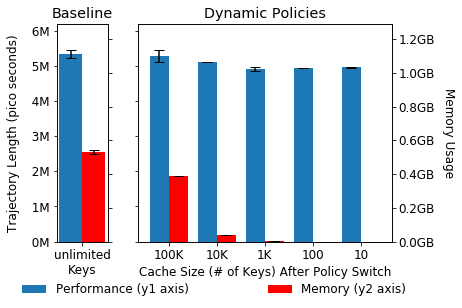

In [196]:
# canvas
fig = plt.figure()#figsize=(16, 4))
gs = plt.GridSpec(1, 2, width_ratios=[1, 5]) 
#fig.subplots_adjust(wspace=0.25)

### FIGURE 0
trajs = []; terror = []
label = []
memory = []; merror = []
for runs in [(d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-71994",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72000",
              d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-72006")]:
    t = []; m = []
    for run in runs:
        t.append(float(get_max_traj(run)['traj']))
        m.append(float(get_max_op("DBMemorySize", run)['count']))
    l = os.path.basename(run).split('-')[3]
    if l != "unlimited":
        l = int(l)
        if l > 100:
            l = str(l / 1000) + str("K")
    l = str(l) + "\nKeys"
    label.append(l)
    trajs.append(float(np.mean(t)))
    terror.append(float(np.std(t)))
    memory.append(float(np.mean(m)))
    merror.append(float(np.std(m)))

ax = plt.subplot(gs[0])
ax.set_title("Baseline")
ax.bar(np.arange(len(trajs)) - 0.2, trajs, yerr=terror, capsize=5, width=0.4, label="Perf (y1)")
ax.set_xticks(range(0, len(trajs)))
ax.set_xticklabels(label)
ax.set_ylabel("Trajectory Length (pico seconds)")
#ax.legend(loc='upper left')
ax.set_ylim(0, 6.2*1000*1000)
ax.set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax.get_yticks()])
ax2 = ax.twinx()
ax2.bar(np.arange(len(memory)) + 0.2, memory, yerr=merror, capsize=5, width=0.4, color='r', label="Memory (y2)")
ax2.set_xticks(range(0, len(memory)))
#ax2.legend(loc='upper right')
ax2.set_ylim(0, 1.2*1024*1024*1024)
#ax2.set_yticklabels(['{:3.1f}GB'.format(yval/(1000*1000*1000)) for yval in ax2.get_yticks()])
ax2.set_yticklabels("")
print trajs, memory
print get_max_op("DBMemoryMapSize", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-71994")

### FIGURE 1
trajs = []; terror = []
label = []
memory = []; merror = []
for runs in [(d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71993",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-71999",
             d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-100000-72005"),
            (d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72374",
             d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72374"),
            (d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-1000-72373",
             d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-1000-72378"),     
            (d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100-72372",
             d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100-72372"),           
            (d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10-72366",
             d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10-72376")    
            ]:
    t = []; m = []
    for run in runs:
        t.append(float(get_max_traj(run)['traj']))
        m.append(float(get_max_op("DBMemorySize", run)['count']))
    l = os.path.basename(run).split('-')[3]
    if l != "unlimited":
        l = int(l)
        if l > 100:
            l = str(l / 1000) + str("K")
    l = str(l)
    label.append(l)
    trajs.append(float(np.mean(t)))
    terror.append(float(np.std(t)))
    memory.append(float(np.mean(m)))
    merror.append(float(np.std(m)))

ax = plt.subplot(gs[1])
ax.set_title("Dynamic Policies")
ax.bar(np.arange(len(trajs)) - 0.2, trajs, yerr=terror, capsize=5, width=0.4, label="Performance (y1 axis)")
ax.set_xticks(range(0, len(trajs)))
ax.set_xticklabels(label)
ax.set_ylim(0, 6.2*1000*1000)
ax.set_yticklabels("")
ax2 = ax.twinx()
ax2.bar(np.arange(len(memory)) + 0.2, memory, yerr=merror, capsize=5, width=0.4, color='r', label="Memory (y2 axis)")
ax2.set_xticks(range(0, len(memory)))
ax.legend(bbox_to_anchor=(-0.5, -0.3), loc='lower left', frameon=False)
ax2.legend(bbox_to_anchor=(1.1, -0.3), loc='lower right', frameon=False)
print trajs, memory

ax2.set_ylim(0, 1.2*1024*1024*1024)
ax2.set_yticklabels(['{:3.1f}GB'.format(yval/(1000*1000*1000)) for yval in ax2.get_yticks()])
ax.set_xlabel("Cache Size (# of Keys) After Policy Switch")
ax2.set_ylabel("Memory Usage", rotation=270, labelpad=20)
fig.savefig("../paper/figures/methodology-tradeoff-dynamic.png", bbox_inches='tight', dpi=400)

## Future Work: Use Machine Learning to Change Policies
Keyspace access and keys looks structured although squished depending on the parameters.

1. Keyspace has structured workload that we can learn what phase we are in
2. We can predict how big the keypsace is because of HPC
3. Feedback loops to create a control system


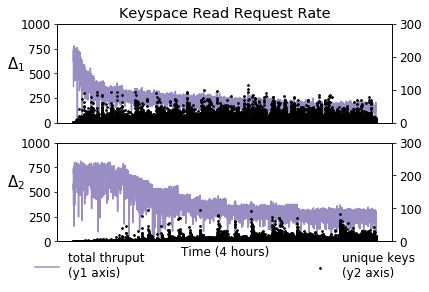

In [205]:
def plot_uniquekeys_per_ts(ax, dfs, key_tuple, ylim=800, shift=0):
    df = dfs[key_tuple]['DF_KEY_TIMES']            # get all timestamps for all keys
    
    df_t = df.groupby('ts').size().reset_index()   # throughput
    df_t.columns=['ts', 'count']
    
    df_u = df.drop_duplicates()                    # only find unique keys by dropping duplicates
    df_u = df_u.groupby('ts').size().reset_index() # for each time stamp, count the unique
    df_u.columns=['ts', 'count']
    
    ax.plot(df_t['ts'], df_t['count'], label="total thruput\n(y1 axis)", color='#998ec3')
    ax2 = ax.twinx()
    ax2.scatter(df_u['ts'], df_u['count'], color='black', s=3, label="unique keys\n(y2 axis)")
    ax.set_ylim(0, 2000)
    ax2.set_ylim(0, 300)
    return ax2

fig, ax = plt.subplots(2, 1)#, figsize=(20, 4))
#fig.subplots_adjust(hspace=.5)
plot_uniquekeys_per_ts(ax[0], dfs, ("4 Node, 100K", "DBMemoryGet", "4"))
ax2 = plot_uniquekeys_per_ts(ax[1], dfs, ("4 Node, 1M", "DBMemoryGet", "4"))
#plot_uniquekeys_per_ts(ax[2], dfs, ("1 Node, 1M", "DBMemoryGet", "4"))

ax[0].set_xlabel("")
for i in range(0, len(ax)):
    ax[i].set_xticklabels([])
    ax[i].set_xticks([])
    ax[i].set_ylim(0, 1000)
ax[1].set_xlabel("Time (4 hours)")
ax[1].legend(bbox_to_anchor=(-0.1, -0.5), loc='lower left', frameon=False)
ax2.legend(bbox_to_anchor=(1.1, -0.5), loc='lower right', frameon=False)
ax[0].set_title("Keyspace Read Request Rate")
ax[0].set_ylabel(r'$\Delta_1$', rotation=360, fontsize=15)
ax[1].set_ylabel(r'$\Delta_2$', rotation=360, fontsize=15)
#ax[2].set_ylabel("1N, 1M")

fig.savefig("../paper/figures/motivation-regimes.png", bbox_inches='tight', dpi=400)

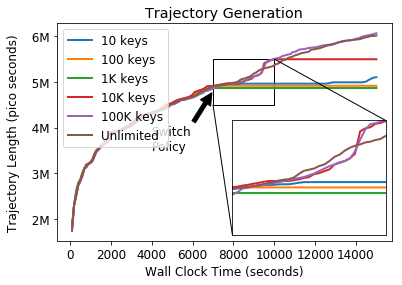

In [173]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

def plot_keyspace(ax, op, results, rank="1", label=""):
    fname = ""
    untar(results + "/out/perf.tar.gz")
    shutil.move("perf/perf." + rank, "tmp/perf." + rank)
    fname = "tmp/perf." + rank
    df = pd.read_csv(fname, names=['ts', 'op', 'count'])
    
    df = df[df['op'] == op]
    shift = np.min(df['ts']) * np.ones(len(df['ts']))
    
    df['cs'] = df['count'].astype(float) - df['count'].shift(1).astype(float)
    ax.plot(df['ts'].astype(float) - shift, df['cs'].astype(float), label=label)
    ax.set_xlabel("Time (seconds)")

fig, ax = plt.subplots(1, 1)
plot_times(ax, "10 keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10-72366")
plot_times(ax, "100 keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100-72361")
plot_times(ax, "1K keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-1000-72378")
plot_times(ax, "10K keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72374")
plot_times(ax, "100K keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100000-72380")
plot_times(ax, "Unlimited", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-71994")
ax.legend(ncol=1, loc='upper left')

#plt.plot([7000, 7000],   [5.5*1000*1000, 4.5*1000*1000], 'k-', lw=2)
#plt.plot([10000, 10000], [5.5*1000*1000, 4.5*1000*1000], 'k-', lw=2)
#plt.plot([7050, 7400],   [4.5*1000*1000, 3.9*1000*1000], 'k-', lw=2)
#plt.plot([10000, 15000], [4.5*1000*1000, 3.9*1000*1000], 'k-', lw=2)

axins = zoomed_inset_axes(ax,2.5,loc=4)
plot_times(axins, "10 Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10-72366")
plot_times(axins, "100 Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100-72361")
plot_times(axins, "1K Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-1000-72378")
plot_times(axins, "10K Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-10000-72374")
plot_times(axins, "100K Keys", d+"nano-sepminima/scale-cachedecrease-all/scale-cachedecrease-8n-100000-72380")
plot_times(axins, "Unlimited", d+"nano-sepminima/scale-reproducibility/scale-cachelimit-8n-unlimited-71994")
axins.set_xlim(7000, 10000)
axins.set_ylim(4.5*1000*1000, 5.5*1000*1000)
axins.legend().remove()
axins.set_ylabel("")
axins.set_xlabel("")
axins.set_xticks([])
axins.set_yticks([])
ax.set_yticklabels(['{:3.0f}M'.format(yval/(1000*1000)) for yval in ax.get_yticks()])
ax.set_title("Trajectory Generation")

mark_inset(ax, axins, loc1=3, loc2=1, color="black", ec="0")
ax.annotate('Switch\nPolicy', xy=(7000, 4.8*1000*1000), xytext=(4000, 3.5*1000*1000),
               arrowprops=dict(facecolor='black', shrink=0.05))


fig.savefig("../paper/figures/methodology-trajectory.png", bbox_inches='tight', dpi=400)